<a href="https://colab.research.google.com/github/kamrun301/24FALL-AI/blob/main/Lab_7_finalipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive


In [140]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path Determine

In [141]:
import os

# Change the path to where your zip file is located in Drive
dataset_path = '/content/drive/My Drive/Caltech-101/archive (1).zip'

# Check if the file exists
print(os.path.exists(dataset_path))  # Should return True if the file is found


True


Unzip File

In [142]:
import zipfile

extract_path = '/content/caltech_101'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction Complete!")


Extraction Complete!


On which file extracted the zip file

In [143]:
print(os.listdir(extract_path))


['caltech-101']


Load the dataset

In [144]:
##Load the dataset
from torchvision import datasets, transforms
transform = transforms.Compose([
transforms.Resize((128, 128)),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.RandomRotation(30),
transforms.ColorJitter(brightness=0.4, contrast=0.4,
saturation=0.4, hue=0.1),
transforms.RandomAffine(degrees=15, translate=(0.1, 0.1),
scale=(0.9, 1.1)),
transforms.RandomGrayscale(p=0.2),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,
0.224, 0.225])
])
dataset = datasets.ImageFolder(root='/content/caltech_101/caltech-101',
transform=transform)

Split Dataset

In [145]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size,
val_size, test_size])

Print the valid images

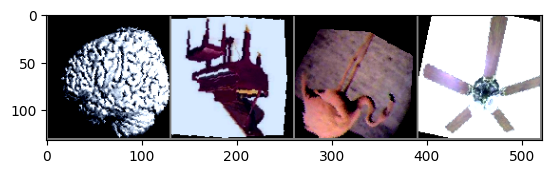

Labels: tensor([14, 47, 42, 21])


In [146]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import utils as vutils

# Create a data loader for the training set
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)

# Get a batch of images and labels
images, labels = next(iter(train_loader))  # Change here: iterating over train_loader

# Display a few images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(vutils.make_grid(images)) # Change here: Using torchvision.utils.make_grid
print("Labels:", labels) # Removed slicing since we have the desired batch size


dataset loader for efficient batching

In [147]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Using pre-trained model
VGG19 model

In [148]:


import torch.nn as nn
from torchvision.models import vgg19

# Load the pre-trained VGG19 model
model = vgg19(pretrained=True)

# Adjust the final layer to output 101 classes
model.classifier[6] = nn.Linear(4096, 101)


ResNet50 Model

In [149]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

model.fc = nn.Linear(2048, 101) # Adjust the final layer for 101 classes

EfficientNet (efficientNet -B0)

In [150]:
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(1280, 101) # Adjust the final layer for 101 classes

Training the model
defining loss and optimizer

In [151]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train the model

In [152]:
from torch.utils.data import Dataset

class FilteredDataset(Dataset):
    def __init__(self, dataset, num_classes):
        self.dataset = dataset
        self.num_classes = num_classes
        self.valid_indices = [
            idx for idx, (_, label) in enumerate(dataset) if 0 <= label < num_classes
        ]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        return self.dataset[valid_idx]

# Replace `train_dataset` and `val_dataset` with filtered versions
filtered_train_dataset = FilteredDataset(train_data, num_classes=101)
filtered_val_dataset = FilteredDataset(val_data, num_classes=101)

# Create DataLoaders
train_loader = DataLoader(filtered_train_dataset, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(filtered_val_dataset, batch_size=10, shuffle=False, num_workers=4, pin_memory=True)

In [153]:
for epoch in range(2):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

validate the model

In [154]:
model.eval()
with torch.no_grad():
     for images, labels in val_loader:
         outputs = model(images)
# Compute validation metrics

In [155]:
# Previous code (loading dataset, defining model, etc.)

# Define Loss and Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
for epoch in range(2):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Validate the Model
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples * 100
print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1.4519312993573354
Epoch 2, Loss: 1.200056919502671
Validation Accuracy: 65.86%


In [156]:
# Verify the maximum label value
print("Max label value in dataset:", max([label for _, label in dataset]))


Max label value in dataset: 101


parameter tuning with grid search

In [157]:
from sklearn.model_selection import ParameterGrid
param_grid = {
'lr': [0.1, 0.01, 0.001],
'batch_size': [16, 32, 64]
}
best_params = None
best_accuracy = 0
for params in ParameterGrid(param_grid):
   optimizer = optim.Adam(model.parameters(), lr=params['lr'])
   train_loader = DataLoader(train_data,
batch_size=params['batch_size'], shuffle=True)
# Perform training and validation here
# Compare and store the best parameters based on validation
#accuracy
print(f"Best Params: {best_params}")

Best Params: None


Evaluating the model
evaluating on test data

In [ ]:
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
# Compute test metrics

confusion matrix

In [159]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_true = []
with torch.no_grad():
     for images, labels in test_loader:
         outputs = model(images)
         _, preds = torch.max(outputs, 1)
         y_pred.extend(preds.numpy())
         y_true.extend(labels.numpy())
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[32  1  0 ...  0  0  0]
 [ 0 39  0 ...  0  0  0]
 [ 0  1 47 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  2  0]
 [ 1  0  0 ...  0  0  0]]


classification report

In [160]:
from sklearn.metrics import classification_report

# Get the class names from the dataset
class_names = dataset.classes

# Now you can use class_names in the classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.67      0.56      0.61        57
            Faces       0.93      0.97      0.95        40
       Faces_easy       0.98      0.98      0.98        48
         Leopards       0.82      1.00      0.90        18
       Motorbikes       1.00      0.95      0.98        85
        accordion       1.00      0.67      0.80         9
        airplanes       0.96      0.97      0.96        88
           anchor       0.00      0.00      0.00         5
              ant       0.50      0.29      0.36         7
           barrel       0.67      0.67      0.67         3
             bass       0.75      0.33      0.46         9
           beaver       1.00      0.43      0.60         7
        binocular       0.00      0.00      0.00         3
           bonsai       0.45      0.62      0.53         8
            brain       0.75      0.75      0.75         8
     brontosaurus       0.57      0.80      0.67       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Top-k Accuracy

In [161]:
#Top-k Accuracy
#python
def top_k_accuracy(output, target, k=5):
   with torch.no_grad():
        max_k_preds = torch.topk(output, k, dim=1).indices
        correct = max_k_preds.eq(target.view(-1,1).expand_as(max_k_preds))
        return correct.any(dim=1).float().mean().item()

Per-class Accuracy

In [162]:
#Per-Class Accuracy
#python
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {class_names[i]} Accuracy: {acc:.2f}")

Class BACKGROUND_Google Accuracy: 0.56
Class Faces Accuracy: 0.97
Class Faces_easy Accuracy: 0.98
Class Leopards Accuracy: 1.00
Class Motorbikes Accuracy: 0.95
Class accordion Accuracy: 0.67
Class airplanes Accuracy: 0.97
Class anchor Accuracy: 0.00
Class ant Accuracy: 0.29
Class barrel Accuracy: 0.67
Class bass Accuracy: 0.33
Class beaver Accuracy: 0.43
Class binocular Accuracy: 0.00
Class bonsai Accuracy: 0.62
Class brain Accuracy: 0.75
Class brontosaurus Accuracy: 0.80
Class buddha Accuracy: 0.17
Class butterfly Accuracy: 0.50
Class camera Accuracy: 1.00
Class cannon Accuracy: 0.00
Class car_side Accuracy: 1.00
Class ceiling_fan Accuracy: 0.25
Class cellphone Accuracy: 1.00
Class chair Accuracy: 0.00
Class chandelier Accuracy: 0.36
Class cougar_body Accuracy: 0.00
Class cougar_face Accuracy: 0.50
Class crab Accuracy: 0.17
Class crayfish Accuracy: 0.00
Class crocodile Accuracy: 0.00
Class crocodile_head Accuracy: 0.29
Class cup Accuracy: 0.33
Class dalmatian Accuracy: 0.33
Class doll

<ipython-input-162-ba848dc6565e>:3: RuntimeWarning: invalid value encountered in divide
  per_class_accuracy = cm.diagonal() / cm.sum(axis=1)


t-SNE visualization

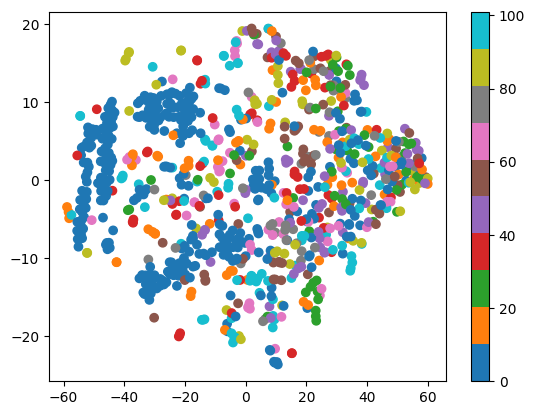

In [163]:
#t-SNE Visualization
#python
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
features = []
labels_list = []
model.eval()
with torch.no_grad():
     for images, labels in test_loader:
         output = model(images)
         features.append(output)
         labels_list.append(labels)

features = torch.cat(features).numpy()
labels_list = torch.cat(labels_list).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1],
c=labels_list, cmap='tab10')
plt.colorbar()
plt.show()

install grad-cam library

In [164]:
#Part 6: Explainable AI (XAI) with Grad-CAM

#Install Grad-CAM Library
#Part 6: Explainable AI (XAI) with Grad-CAM

#Install Grad-CAM Library
#bash

!pip install grad-cam

apply grad-cam

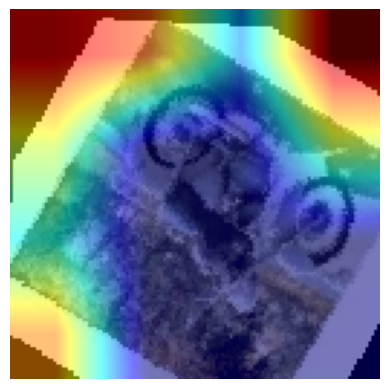

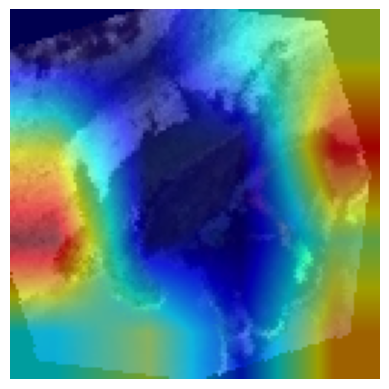

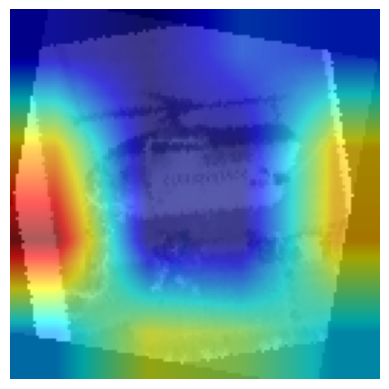

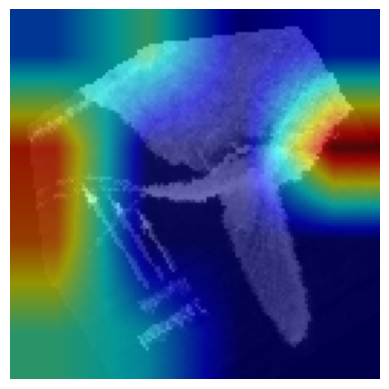

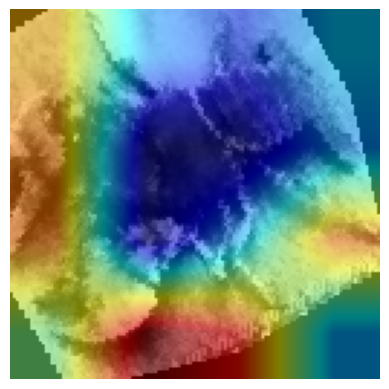

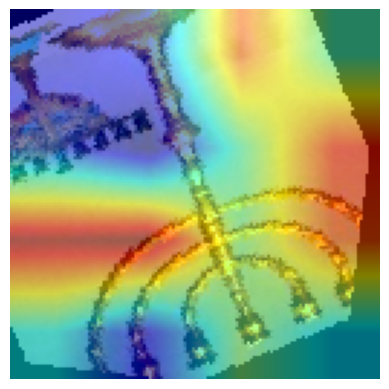

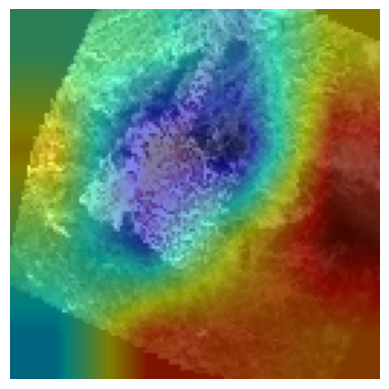

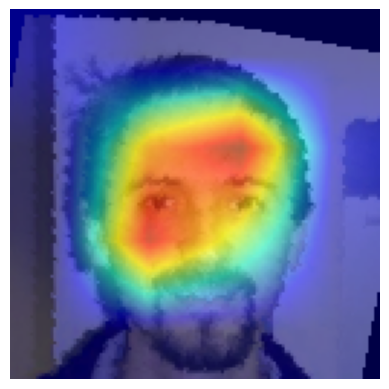

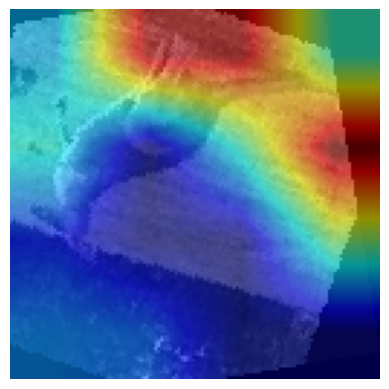

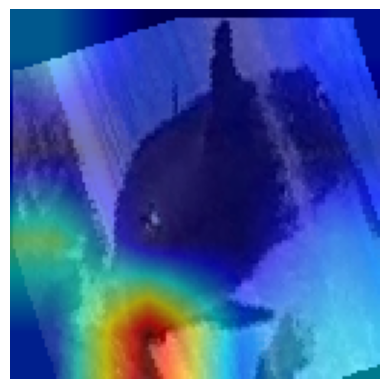

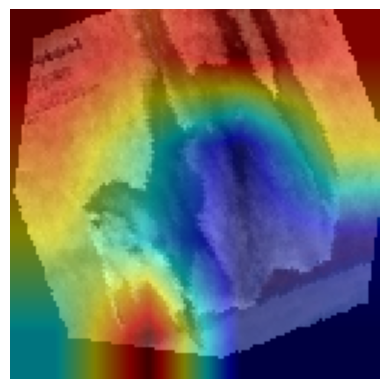

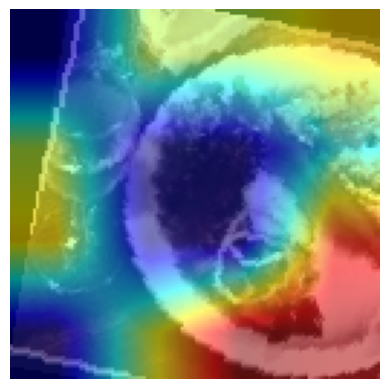

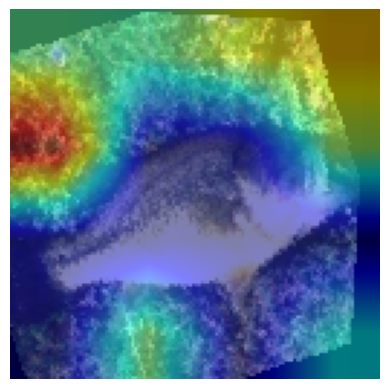

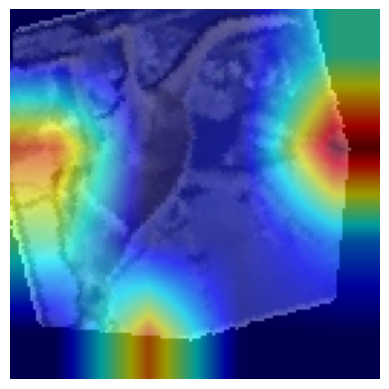

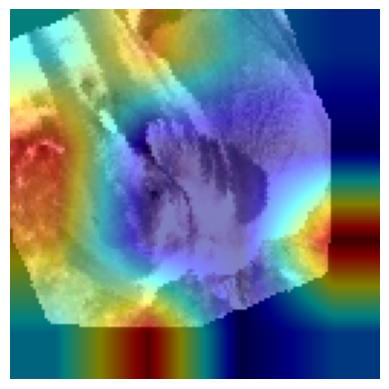

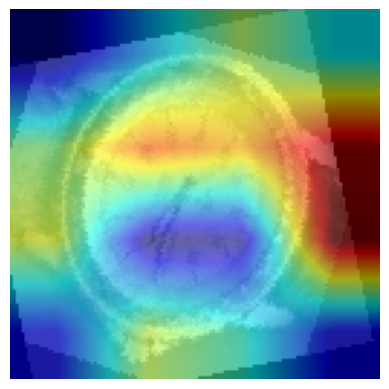

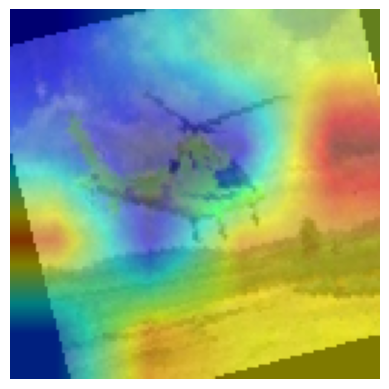

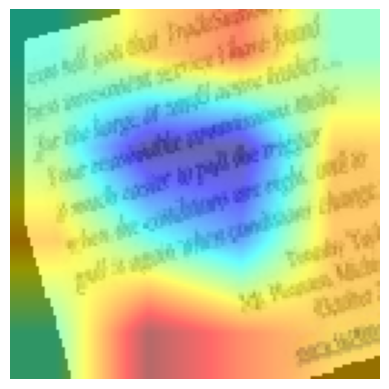

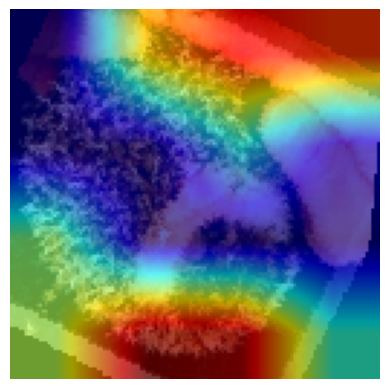

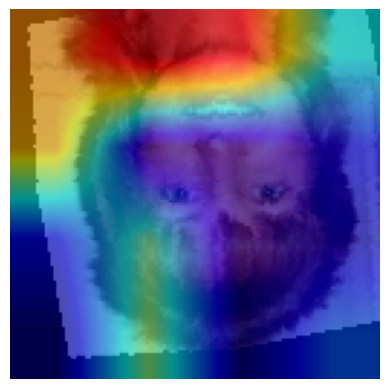

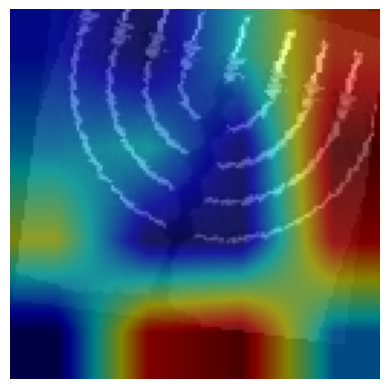

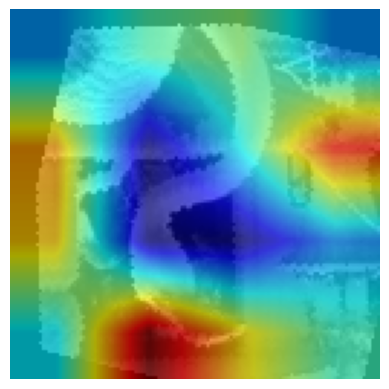

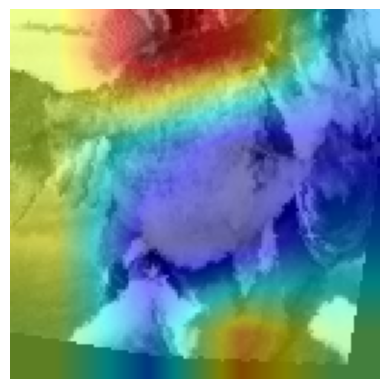

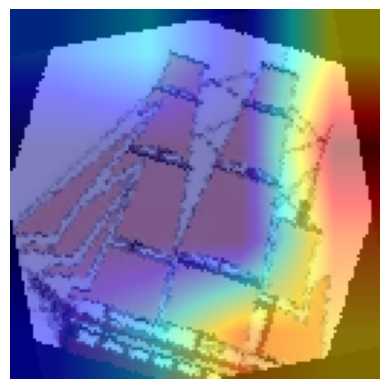

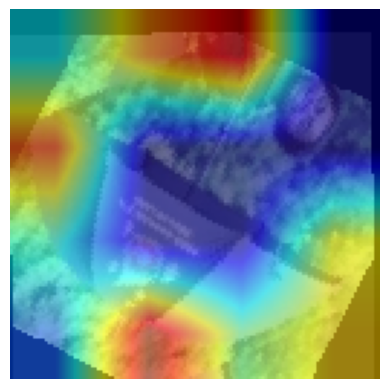

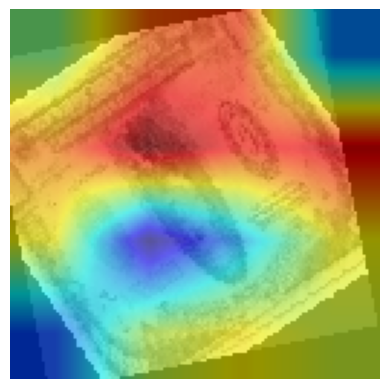

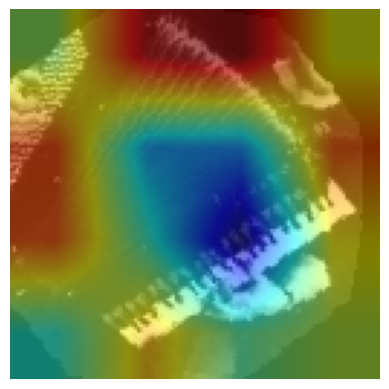

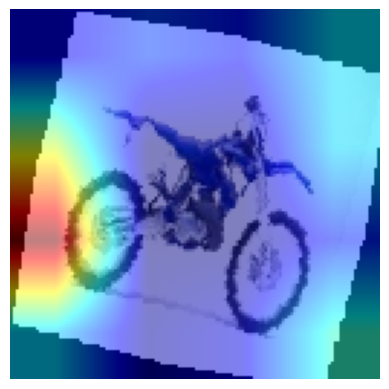

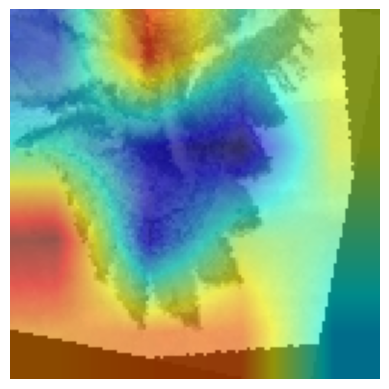

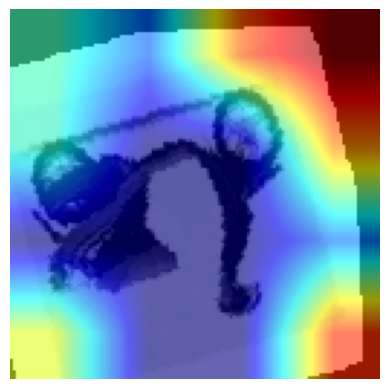

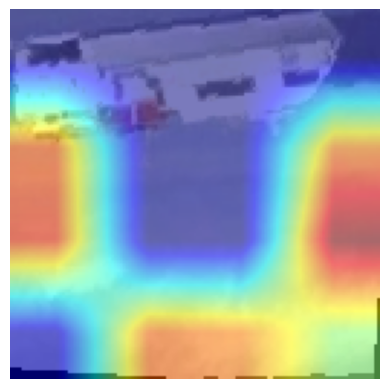

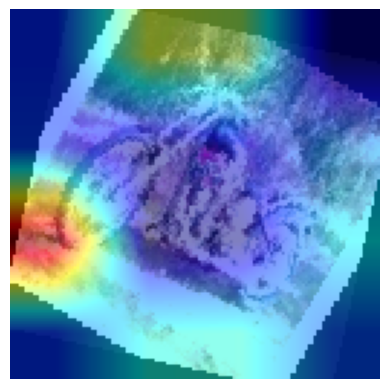

In [165]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch

# ... (rest of your imports) ...

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ... (previous code) ...

# Identify the last convolutional layer for EfficientNet
target_layers = [model.features[-1]]  # List of layers as required by the updated API

# Instantiate GradCAM without 'use_cuda'
cam = GradCAM(model=model, target_layers=target_layers)  # Remove use_cuda

# Process images through the test loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Generate Grad-CAM visualization
    grayscale_cam = cam(input_tensor=images, targets=None)
    for i in range(len(images)):
        # Denormalize the image before passing it to show_cam_on_image
        denormalized_image = images[i].permute(1, 2, 0).cpu().numpy()
        # Assuming your images were normalized using ImageNet stats
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        for j in range(3):  # Iterate through RGB channels
            denormalized_image[:, :, j] = (denormalized_image[:, :, j] * std[j]) + mean[j]

        # Clip pixel values to the [0, 1] range
        denormalized_image = np.clip(denormalized_image, 0, 1)

        cam_image = show_cam_on_image(
            denormalized_image,  # Pass the denormalized image
            grayscale_cam[i],
            use_rgb=True
        )

        plt.imshow(cam_image)
        plt.axis("off")
        plt.show()
    break